In [1]:
from __future__ import print_function
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import keras
from sklearn.decomposition import PCA
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam, Nadam
import time
import os
#print(os.listdir("./npy_landuse"))

In [2]:
batch_size = 128
num_classes = 2
epochs = 10

In [3]:
x_train = np.load('./npy_covid64/x_train.npy')
y_train = np.load('./npy_covid64/y_train.npy')
x_test=np.load('./npy_covid64/x_test.npy')
y_test=np.load('./npy_covid64/y_test.npy')

In [4]:
x_train.shape

(11588, 64, 64)

In [5]:
x_test.shape

(2898, 64, 64)

In [6]:
y_test.shape

(2898, 2)

In [7]:
# Change from matrix to array --> dimension 64x64 to array of dimention 4096
x_train = x_train.reshape(11588, 4096)
x_test = x_test.reshape(2898, 4096)

In [8]:
y_test.shape

(2898, 2)

In [9]:
# Change to float datatype
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Scale the data to lie between 0 to 1
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

11588 train samples
2898 test samples


In [10]:
# PCA
pca = PCA(n_components=100)

x_train=pca.fit_transform(x_train)
x_test= pca.transform(x_test)

In [11]:
#                      BUILDING THE MODEL
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(100,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
nadam=keras.optimizers.Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=nadam,
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               51712     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 315,394
Trainable params: 315,394
Non-trainable params: 0
_________________________________________________________________


In [12]:
start = time.time() # Measuring the processing time
#                      TRAINING THE MODEL
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test, y_test))
end = time.time()
print(end - start)


Epoch 1/100
91/91 [==============================] - 1s 10ms/step - loss: 0.5394 - accuracy: 0.7906 - val_loss: 0.4060 - val_accuracy: 0.8043
Epoch 2/100
91/91 [==============================] - 1s 8ms/step - loss: 0.3528 - accuracy: 0.8566 - val_loss: 0.3283 - val_accuracy: 0.8789
Epoch 3/100
91/91 [==============================] - 1s 8ms/step - loss: 0.3111 - accuracy: 0.8761 - val_loss: 0.3020 - val_accuracy: 0.8903
Epoch 4/100
91/91 [==============================] - 1s 8ms/step - loss: 0.2934 - accuracy: 0.8823 - val_loss: 0.2877 - val_accuracy: 0.8927
Epoch 5/100
91/91 [==============================] - 1s 7ms/step - loss: 0.2817 - accuracy: 0.8890 - val_loss: 0.2821 - val_accuracy: 0.8965
Epoch 6/100
91/91 [==============================] - 1s 8ms/step - loss: 0.2710 - accuracy: 0.8952 - val_loss: 0.2850 - val_accuracy: 0.8968
Epoch 7/100
91/91 [==============================] - 1s 8ms/step - loss: 0.2549 - accuracy: 0.9027 - val_loss: 0.2664 - val_accuracy: 0.8999
Epoch 8/100


In [13]:
#                      EVALUATE TRAINED MODEL
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.07964995503425598
Test accuracy: 0.9830917716026306


In [14]:
model.save('mlp_weights_1.h5')

In [15]:
model.load_weights('mlp_weights_1.h5')

In [16]:
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense_2').output)

feat_train = model_feat.predict(x_train)
print(feat_train.shape)

#feat_val = model_feat.predict(x_val)
#print(feat_val.shape)

feat_test = model_feat.predict(x_test)
print(feat_test.shape)

(11588, 2)
(2898, 2)


In [17]:
from keras import metrics
from sklearn.metrics import confusion_matrix

In [18]:
pred = model.predict_classes(x_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [19]:
confusion_matrix(pred, np.argmax(y_test,axis =1))

array([[1368,   35],
       [  14, 1481]], dtype=int64)

In [20]:
import seaborn as sns

In [20]:
def plot_heatmap(cm,title):
    df_cm2 = pd.DataFrame(cm, index = ['No Covid','Covid'])
    df_cm2.columns=['No Covid','Covid']
    f,ax = plt.subplots(figsize=(12, 12))
    #ax = plt.axes()
    sns.heatmap(df_cm2, annot=True, fmt="d", linewidths=.5,ax=ax)
    ax.set_title(title)
    plt.show()

    
    return

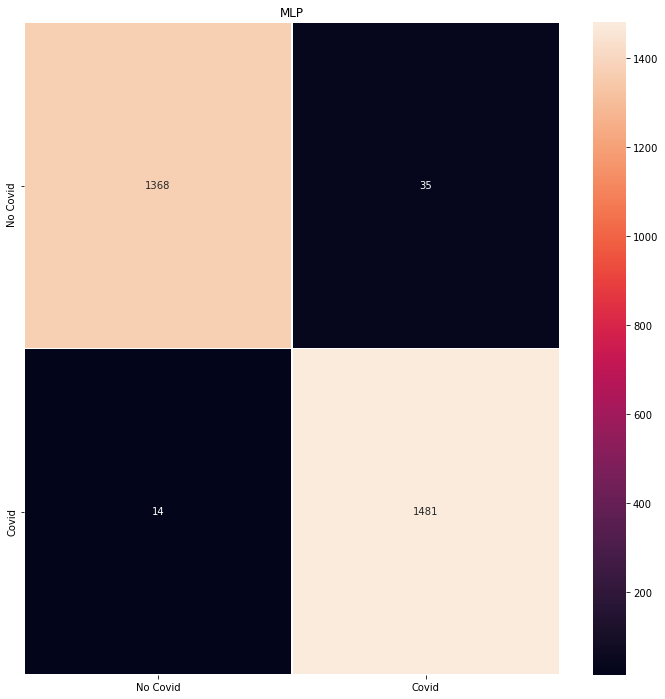

In [21]:
plot_heatmap(confusion_matrix(pred, np.argmax(y_test,axis =1)),'MLP')

In [22]:
from sklearn.metrics import classification_report
print(classification_report(pred, np.argmax(y_test,axis =1),digits=4))

              precision    recall  f1-score   support

           0     0.9899    0.9751    0.9824      1403
           1     0.9769    0.9906    0.9837      1495

    accuracy                         0.9831      2898
   macro avg     0.9834    0.9828    0.9831      2898
weighted avg     0.9832    0.9831    0.9831      2898



In [23]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')
start = time.time() # Measuring the processing time
svm.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start)


print('fitting done !!!')

0.27354979515075684
fitting done !!!


In [24]:
svm.score(feat_train,np.argmax(y_train,axis=1))

0.9989644459785986

In [25]:
svm.score(feat_test,np.argmax(y_test,axis=1))

0.9830917874396136

In [26]:
Pred_labels = svm.predict(feat_test)

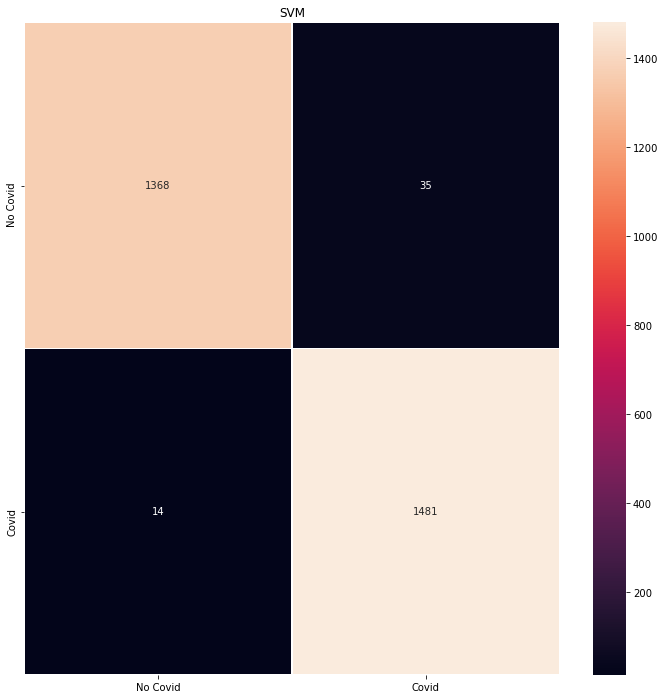

In [27]:
plot_heatmap(confusion_matrix(pred, np.argmax(y_test,axis =1)),'SVM')

In [28]:
print(classification_report(Pred_labels, np.argmax(y_test,axis =1),digits=4))

              precision    recall  f1-score   support

           0     0.9877    0.9771    0.9824      1397
           1     0.9789    0.9887    0.9838      1501

    accuracy                         0.9831      2898
   macro avg     0.9833    0.9829    0.9831      2898
weighted avg     0.9831    0.9831    0.9831      2898



# Applying XGBOOST

In [29]:
import xgboost as xgb

xb = xgb.XGBClassifier()
start = time.time() # Measuring the processing time
xb.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start)

print('fitting done !!!')

0.2771589756011963
fitting done !!!


In [30]:
xb.score(feat_train,np.argmax(y_train,axis=1))

0.9998274076630997

In [31]:
xb.score(feat_test,np.argmax(y_test,axis=1))

0.9827467218771566

In [32]:
Pred_labels = xb.predict(feat_test)

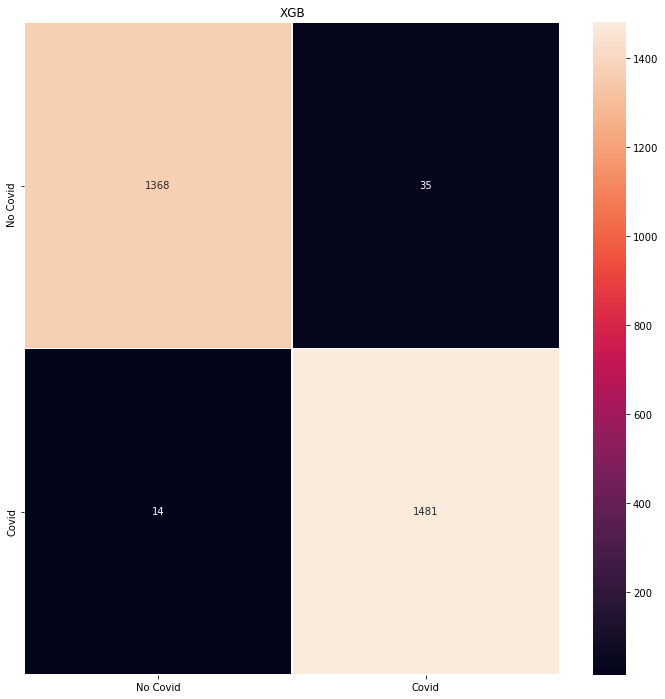

In [33]:
plot_heatmap(confusion_matrix(pred, np.argmax(y_test,axis =1)),'XGB')

In [34]:
print(classification_report(Pred_labels, np.argmax(y_test,axis =1),digits=4))

              precision    recall  f1-score   support

           0     0.9877    0.9764    0.9820      1398
           1     0.9782    0.9887    0.9834      1500

    accuracy                         0.9827      2898
   macro avg     0.9830    0.9825    0.9827      2898
weighted avg     0.9828    0.9827    0.9827      2898



In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection

In [36]:
lr = LogisticRegression()
start = time.time() # Measuring the processing time
lr.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start)

print('fitting done !!!')

0.33734869956970215
fitting done !!!


In [37]:
Pred_labels = lr.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1),digits=4))

              precision    recall  f1-score   support

           0     0.9891    0.9750    0.9820      1402
           1     0.9769    0.9900    0.9834      1496

    accuracy                         0.9827      2898
   macro avg     0.9830    0.9825    0.9827      2898
weighted avg     0.9828    0.9827    0.9827      2898



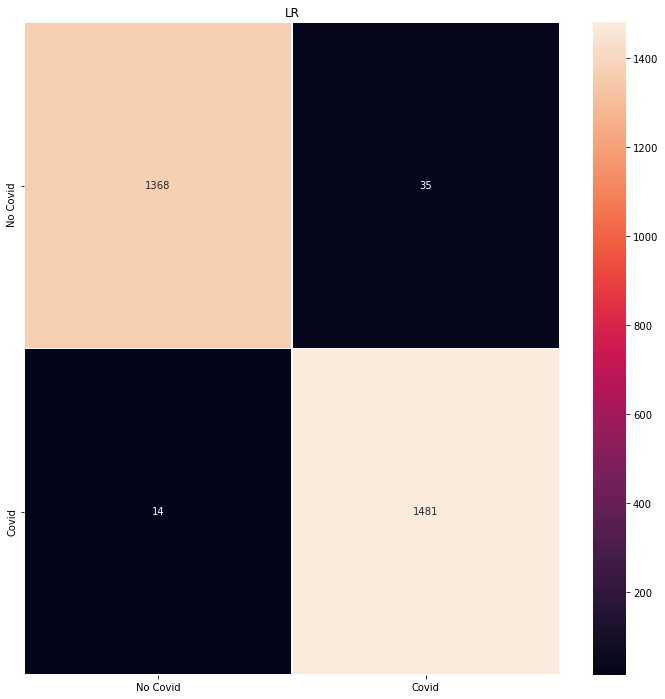

In [38]:
plot_heatmap(confusion_matrix(pred, np.argmax(y_test,axis =1)),'LR')

In [39]:
dt = DecisionTreeClassifier()
start = time.time() # Measuring the processing time
dt.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start)

print('fitting done !!!')
Pred_labels = dt.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1),digits=4))

0.19976305961608887
fitting done !!!
              precision    recall  f1-score   support

           0     0.9877    0.9764    0.9820      1398
           1     0.9782    0.9887    0.9834      1500

    accuracy                         0.9827      2898
   macro avg     0.9830    0.9825    0.9827      2898
weighted avg     0.9828    0.9827    0.9827      2898



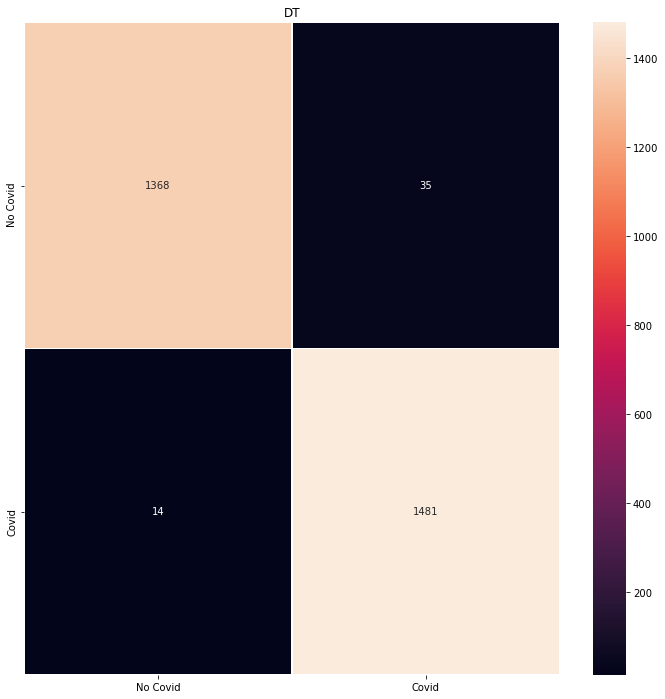

In [40]:
plot_heatmap(confusion_matrix(pred, np.argmax(y_test,axis =1)),'DT')

In [41]:
knn = KNeighborsClassifier()
start = time.time() # Measuring the processing time
knn.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start)

print('fitting done !!!')
Pred_labels = knn.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1),digits=4))

0.22854828834533691
fitting done !!!
              precision    recall  f1-score   support

           0     0.9863    0.9792    0.9827      1392
           1     0.9809    0.9874    0.9841      1506

    accuracy                         0.9834      2898
   macro avg     0.9836    0.9833    0.9834      2898
weighted avg     0.9835    0.9834    0.9834      2898



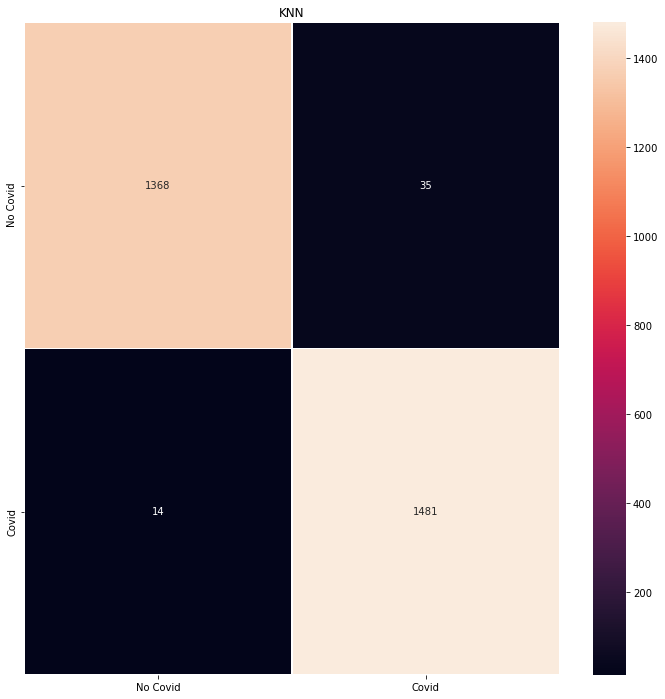

In [42]:
plot_heatmap(confusion_matrix(pred, np.argmax(y_test,axis =1)),'KNN')

In [43]:
lda = LinearDiscriminantAnalysis()
start = time.time() # Measuring the processing time
lda.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start)

print('fitting done !!!')
Pred_labels = lda.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1),digits=4))

0.33287572860717773
fitting done !!!
              precision    recall  f1-score   support

           0     0.9899    0.9751    0.9824      1403
           1     0.9769    0.9906    0.9837      1495

    accuracy                         0.9831      2898
   macro avg     0.9834    0.9828    0.9831      2898
weighted avg     0.9832    0.9831    0.9831      2898



In [44]:
nb = GaussianNB()
start = time.time() # Measuring the processing time
nb.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start)

print('fitting done !!!')
Pred_labels = nb.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1),digits=4))

0.0039637088775634766
fitting done !!!
              precision    recall  f1-score   support

           0     0.9877    0.9771    0.9824      1397
           1     0.9789    0.9887    0.9838      1501

    accuracy                         0.9831      2898
   macro avg     0.9833    0.9829    0.9831      2898
weighted avg     0.9831    0.9831    0.9831      2898



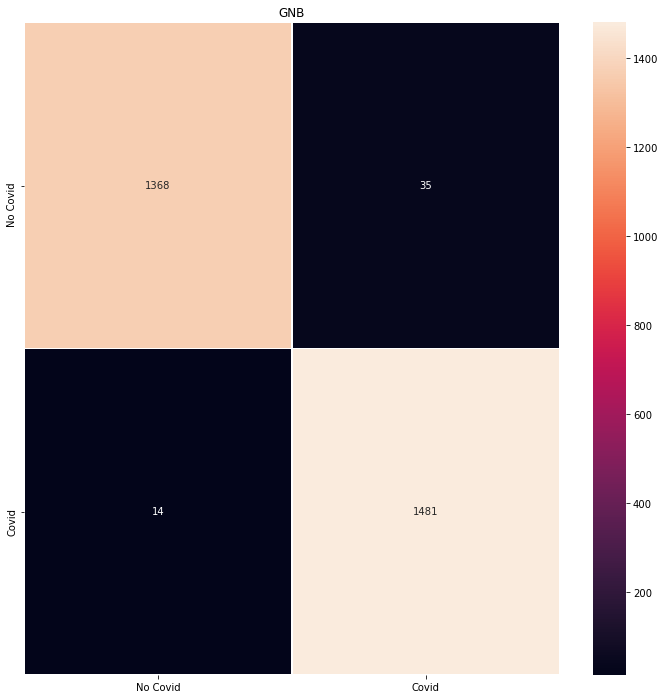

In [45]:
plot_heatmap(confusion_matrix(pred, np.argmax(y_test,axis =1)),'GNB')

In [46]:
et = ExtraTreesClassifier()
start = time.time() # Measuring the processing time
et.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start)

print('fitting done !!!')
Pred_labels = et.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1),digits=4))

0.29716944694519043
fitting done !!!
              precision    recall  f1-score   support

           0     0.9870    0.9757    0.9813      1398
           1     0.9776    0.9880    0.9828      1500

    accuracy                         0.9821      2898
   macro avg     0.9823    0.9818    0.9820      2898
weighted avg     0.9821    0.9821    0.9821      2898



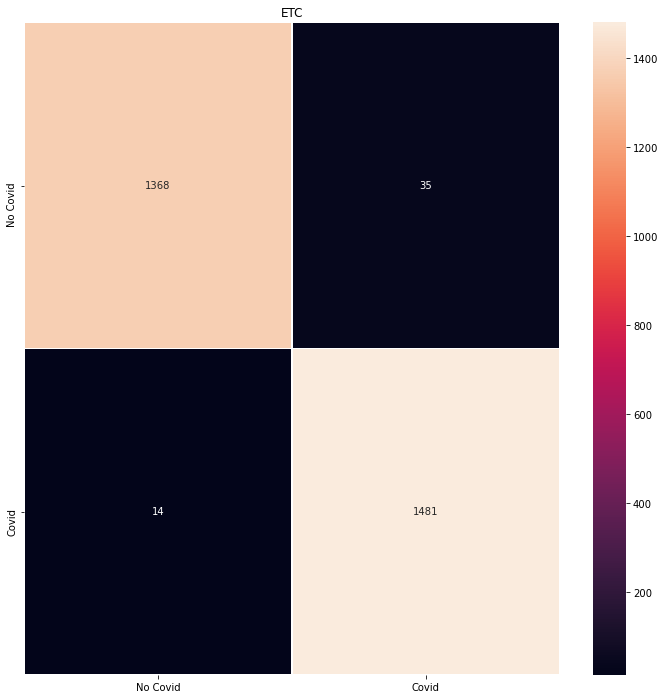

In [47]:
plot_heatmap(confusion_matrix(pred, np.argmax(y_test,axis =1)),'ETC')

In [53]:
rf = RandomForestClassifier()
start = time.time() # Measuring the processing time
rf.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total

print('fitting done !!!')
Pred_labels = et.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

0.4670100212097168
fitting done !!!
              precision    recall  f1-score   support

           0     0.9870    0.9757    0.9813      1398
           1     0.9776    0.9880    0.9828      1500

    accuracy                         0.9821      2898
   macro avg     0.9823    0.9818    0.9820      2898
weighted avg     0.9821    0.9821    0.9821      2898



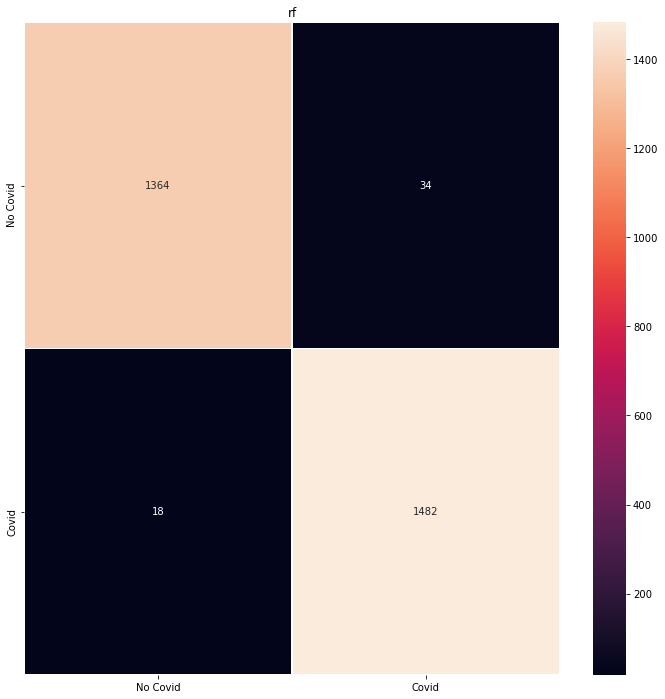

In [54]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'rf')

In [55]:
import lightgbm as lgb
lg = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
start = time.time() # Measuring the processing time
lg.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total

print('fitting done !!!')
Pred_labels = et.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

0.05454230308532715
fitting done !!!
              precision    recall  f1-score   support

           0     0.9870    0.9757    0.9813      1398
           1     0.9776    0.9880    0.9828      1500

    accuracy                         0.9821      2898
   macro avg     0.9823    0.9818    0.9820      2898
weighted avg     0.9821    0.9821    0.9821      2898



In [56]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier()
start = time.time() # Measuring the processing time
cb.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total

print('fitting done !!!')
Pred_labels = et.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

Learning rate set to 0.029327
0:	learn: 0.5835965	total: 164ms	remaining: 2m 43s
1:	learn: 0.5011158	total: 170ms	remaining: 1m 25s
2:	learn: 0.4207281	total: 177ms	remaining: 58.9s
3:	learn: 0.3582554	total: 189ms	remaining: 47s
4:	learn: 0.3028806	total: 196ms	remaining: 39s
5:	learn: 0.2581205	total: 204ms	remaining: 33.8s
6:	learn: 0.2227292	total: 210ms	remaining: 29.8s
7:	learn: 0.1957670	total: 216ms	remaining: 26.8s
8:	learn: 0.1721935	total: 222ms	remaining: 24.4s
9:	learn: 0.1484378	total: 228ms	remaining: 22.6s
10:	learn: 0.1267498	total: 235ms	remaining: 21.2s
11:	learn: 0.1099361	total: 241ms	remaining: 19.9s
12:	learn: 0.0952810	total: 248ms	remaining: 18.8s
13:	learn: 0.0829570	total: 254ms	remaining: 17.9s
14:	learn: 0.0724187	total: 260ms	remaining: 17.1s
15:	learn: 0.0633541	total: 267ms	remaining: 16.4s
16:	learn: 0.0553750	total: 274ms	remaining: 15.8s
17:	learn: 0.0480693	total: 280ms	remaining: 15.3s
18:	learn: 0.0428878	total: 286ms	remaining: 14.8s
19:	learn: 0.

172:	learn: 0.0036519	total: 1.21s	remaining: 5.8s
173:	learn: 0.0036519	total: 1.22s	remaining: 5.78s
174:	learn: 0.0036519	total: 1.22s	remaining: 5.77s
175:	learn: 0.0036519	total: 1.23s	remaining: 5.75s
176:	learn: 0.0036519	total: 1.23s	remaining: 5.74s
177:	learn: 0.0036519	total: 1.24s	remaining: 5.74s
178:	learn: 0.0036519	total: 1.25s	remaining: 5.72s
179:	learn: 0.0036519	total: 1.25s	remaining: 5.71s
180:	learn: 0.0036518	total: 1.26s	remaining: 5.69s
181:	learn: 0.0036518	total: 1.26s	remaining: 5.68s
182:	learn: 0.0036518	total: 1.27s	remaining: 5.66s
183:	learn: 0.0036518	total: 1.27s	remaining: 5.65s
184:	learn: 0.0036518	total: 1.28s	remaining: 5.64s
185:	learn: 0.0036518	total: 1.28s	remaining: 5.63s
186:	learn: 0.0036518	total: 1.29s	remaining: 5.61s
187:	learn: 0.0036518	total: 1.3s	remaining: 5.6s
188:	learn: 0.0036518	total: 1.3s	remaining: 5.59s
189:	learn: 0.0036518	total: 1.31s	remaining: 5.57s
190:	learn: 0.0036518	total: 1.31s	remaining: 5.56s
191:	learn: 0.00

345:	learn: 0.0034922	total: 2.08s	remaining: 3.93s
346:	learn: 0.0034922	total: 2.08s	remaining: 3.92s
347:	learn: 0.0034922	total: 2.09s	remaining: 3.92s
348:	learn: 0.0034922	total: 2.1s	remaining: 3.91s
349:	learn: 0.0034922	total: 2.1s	remaining: 3.9s
350:	learn: 0.0034922	total: 2.12s	remaining: 3.92s
351:	learn: 0.0034922	total: 2.14s	remaining: 3.94s
352:	learn: 0.0034922	total: 2.15s	remaining: 3.93s
353:	learn: 0.0034921	total: 2.15s	remaining: 3.92s
354:	learn: 0.0034921	total: 2.15s	remaining: 3.91s
355:	learn: 0.0034921	total: 2.16s	remaining: 3.91s
356:	learn: 0.0034921	total: 2.16s	remaining: 3.9s
357:	learn: 0.0034921	total: 2.17s	remaining: 3.89s
358:	learn: 0.0034921	total: 2.17s	remaining: 3.88s
359:	learn: 0.0034921	total: 2.18s	remaining: 3.88s
360:	learn: 0.0034921	total: 2.19s	remaining: 3.87s
361:	learn: 0.0034921	total: 2.19s	remaining: 3.86s
362:	learn: 0.0034921	total: 2.2s	remaining: 3.86s
363:	learn: 0.0034921	total: 2.21s	remaining: 3.85s
364:	learn: 0.003

521:	learn: 0.0034533	total: 2.93s	remaining: 2.68s
522:	learn: 0.0034533	total: 2.93s	remaining: 2.68s
523:	learn: 0.0034533	total: 2.94s	remaining: 2.67s
524:	learn: 0.0034533	total: 2.94s	remaining: 2.66s
525:	learn: 0.0034533	total: 2.95s	remaining: 2.66s
526:	learn: 0.0034533	total: 2.96s	remaining: 2.65s
527:	learn: 0.0034533	total: 2.96s	remaining: 2.65s
528:	learn: 0.0034533	total: 2.97s	remaining: 2.64s
529:	learn: 0.0034533	total: 2.97s	remaining: 2.63s
530:	learn: 0.0034533	total: 2.98s	remaining: 2.63s
531:	learn: 0.0034533	total: 2.98s	remaining: 2.62s
532:	learn: 0.0034533	total: 2.99s	remaining: 2.62s
533:	learn: 0.0034533	total: 2.99s	remaining: 2.61s
534:	learn: 0.0034533	total: 2.99s	remaining: 2.6s
535:	learn: 0.0034533	total: 3s	remaining: 2.6s
536:	learn: 0.0034533	total: 3s	remaining: 2.59s
537:	learn: 0.0034533	total: 3.01s	remaining: 2.58s
538:	learn: 0.0034533	total: 3.01s	remaining: 2.58s
539:	learn: 0.0034533	total: 3.02s	remaining: 2.57s
540:	learn: 0.003453

682:	learn: 0.0034533	total: 3.63s	remaining: 1.69s
683:	learn: 0.0034533	total: 3.64s	remaining: 1.68s
684:	learn: 0.0034533	total: 3.64s	remaining: 1.67s
685:	learn: 0.0034533	total: 3.64s	remaining: 1.67s
686:	learn: 0.0034533	total: 3.65s	remaining: 1.66s
687:	learn: 0.0034533	total: 3.65s	remaining: 1.66s
688:	learn: 0.0034533	total: 3.66s	remaining: 1.65s
689:	learn: 0.0034533	total: 3.66s	remaining: 1.65s
690:	learn: 0.0034533	total: 3.67s	remaining: 1.64s
691:	learn: 0.0034533	total: 3.67s	remaining: 1.63s
692:	learn: 0.0034533	total: 3.67s	remaining: 1.63s
693:	learn: 0.0034533	total: 3.68s	remaining: 1.62s
694:	learn: 0.0034533	total: 3.68s	remaining: 1.62s
695:	learn: 0.0034533	total: 3.69s	remaining: 1.61s
696:	learn: 0.0034533	total: 3.69s	remaining: 1.6s
697:	learn: 0.0034533	total: 3.69s	remaining: 1.6s
698:	learn: 0.0034533	total: 3.7s	remaining: 1.59s
699:	learn: 0.0034533	total: 3.7s	remaining: 1.59s
700:	learn: 0.0034533	total: 3.71s	remaining: 1.58s
701:	learn: 0.00

846:	learn: 0.0034533	total: 4.32s	remaining: 780ms
847:	learn: 0.0034533	total: 4.32s	remaining: 775ms
848:	learn: 0.0034533	total: 4.33s	remaining: 770ms
849:	learn: 0.0034533	total: 4.33s	remaining: 765ms
850:	learn: 0.0034533	total: 4.34s	remaining: 760ms
851:	learn: 0.0034533	total: 4.34s	remaining: 755ms
852:	learn: 0.0034533	total: 4.35s	remaining: 749ms
853:	learn: 0.0034533	total: 4.35s	remaining: 744ms
854:	learn: 0.0034533	total: 4.36s	remaining: 739ms
855:	learn: 0.0034533	total: 4.36s	remaining: 734ms
856:	learn: 0.0034533	total: 4.36s	remaining: 728ms
857:	learn: 0.0034533	total: 4.37s	remaining: 723ms
858:	learn: 0.0034533	total: 4.37s	remaining: 718ms
859:	learn: 0.0034533	total: 4.38s	remaining: 713ms
860:	learn: 0.0034533	total: 4.38s	remaining: 707ms
861:	learn: 0.0034533	total: 4.38s	remaining: 702ms
862:	learn: 0.0034533	total: 4.39s	remaining: 697ms
863:	learn: 0.0034533	total: 4.39s	remaining: 692ms
864:	learn: 0.0034533	total: 4.4s	remaining: 686ms
865:	learn: 0

In [48]:
estimators = list()
estimators.append(('RF', RandomForestClassifier()))
estimators.append(('LR', LogisticRegression()))
estimators.append(('DTC', DecisionTreeClassifier()))
estimators.append(('KNN', KNeighborsClassifier()))
estimators.append(('LDA', LinearDiscriminantAnalysis()))
estimators.append(('NB', GaussianNB()))
#estimators.append(('SVM', GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=40, min_samples_leaf=7,max_features=4 , subsample=0.95, random_state=10)))
estimators.append(('XGB', XGBClassifier()))

In [49]:
ensemble = VotingClassifier(estimators=estimators, voting='soft')
start = time.time() # Measuring the processing time
ensemble.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start)

print('fitting done !!!')
Pred_labels = ensemble.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1),digits=4))

0.6259691715240479
fitting done !!!
              precision    recall  f1-score   support

           0     0.9877    0.9771    0.9824      1397
           1     0.9789    0.9887    0.9838      1501

    accuracy                         0.9831      2898
   macro avg     0.9833    0.9829    0.9831      2898
weighted avg     0.9831    0.9831    0.9831      2898



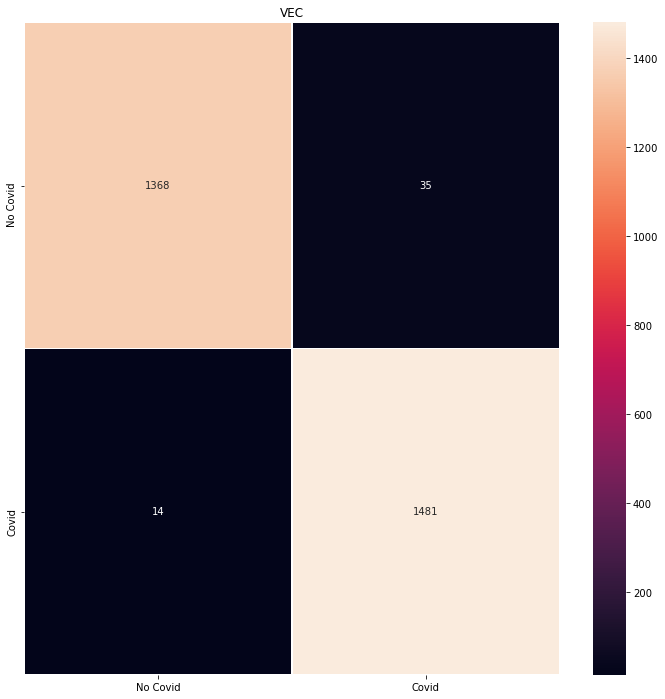

In [50]:
plot_heatmap(confusion_matrix(pred, np.argmax(y_test,axis =1)),'VEC')

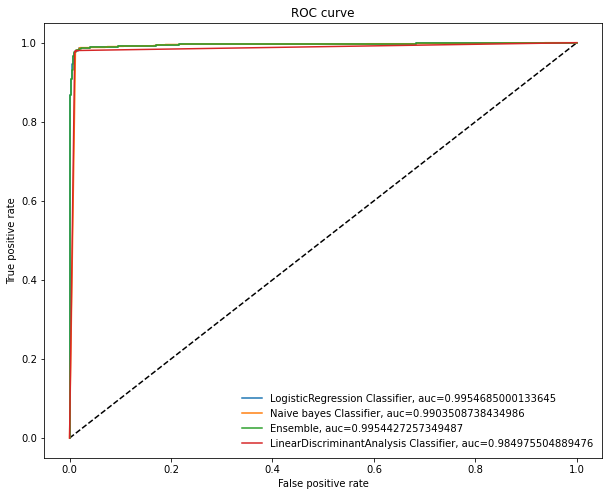

In [52]:
from sklearn import metrics
from sklearn.metrics import roc_curve


clf2=LogisticRegression().fit(feat_train,np.argmax(y_train,axis=1))
y_pred2 = clf2.predict(feat_test)

clf3 = GaussianNB().fit(feat_train,np.argmax(y_train,axis=1))
y_pred3 = clf3.predict(feat_test)

clf4 = ensemble.fit(feat_train,np.argmax(y_train,axis=1))
y_pred4 = clf4.predict(feat_test)

clf6=LinearDiscriminantAnalysis().fit(feat_train,np.argmax(y_train,axis=1))
y_pred6 = clf6.predict(feat_test)

#clf7=SVC(kernel='rbf').fit(feat_train,np.argmax(y_train,axis=1))
#y_pred7 = clf7.predict(feat_test)

y_pred_proba2 = clf2.predict_proba(feat_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba2)
auc2 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba2)

y_pred_proba3 = clf3.predict_proba(feat_test)[::,1]
fpr3, tpr3, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba3)
auc3 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba3)

y_pred_proba4 = clf4.predict_proba(feat_test)[::,1]
fpr4, tpr4, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba4)
auc4 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba4)

y_pred_proba6 = clf6.predict_proba(feat_test)[::,1]
fpr6, tpr6, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba6)
auc6 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba6)

#y_pred_proba7 = clf7.predict_proba(feat_test)[::,1]
#fpr7, tpr7, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba7)
#auc7 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba7)


plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr2,tpr2,label="LogisticRegression Classifier, auc="+str(auc2))
plt.plot(fpr3,tpr3,label="Naive bayes Classifier, auc="+str(auc3))
plt.plot(fpr4,tpr4,label="Ensemble, auc="+str(auc4))
plt.plot(fpr6,tpr6,label="LinearDiscriminantAnalysis Classifier, auc="+str(auc6))
#plt.plot(fpr7,tpr7,label="SVC Classifier, auc="+str(auc7))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(frameon=False)
plt.show()